# Data-analysis, group 3
Our subjects: 3,5,11,17,19,25,31,33

In [1]:
# imports and stuff
from dataclasses import dataclass
from typing import List, Optional
import matplotlib.pyplot as plt
import statistics as stat
import pandas as pd
import numpy as np
import csv


c:\Python\Python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1. Reading the data

In [2]:
# constants and helper variables
subjects = [3, 5, 11, 17, 19, 25, 31, 33]
subjects_formatted = ['s' + str(s) for s in subjects]


In [3]:
@dataclass
class Sample:
    """Class for a sample from the data"""
    sid: str
    known: bool
    xi: Optional[List[float]] = None
    yi: Optional[List[float]] = None


In [4]:
def parse_line(line) -> List:
    return line.split(',')


def parse_classes(lines) -> List[Sample]:
    parsed_lines = [parse_line(line) for line in lines]
    return [Sample(line[0], line[1], line[2::2], line[3::2]) for line in parsed_lines]


In [5]:
# reading the lines
with open('data/train.csv') as f:
    lines = f.readlines()

    our_lines = [line for line in lines
                 if line.split(',')[0]
                 in subjects_formatted]

    samples = parse_classes(our_lines)

    sample_dict = {}

    for sample in samples:
        sample_dict.setdefault(sample.sid, []).append(sample)
        
    for key, val in sample_dict.items():
        print(key, len(val))


s5 34
s17 23
s19 14
s31 33
s3 29
s11 10
s25 17
s33 33


## 2. Fixation detection algorithm

In [6]:
def get_dispersion(x, y):
    """Calculate dispersion, idea from: https://github.com/ecekt/eyegaze

    Args:
        x (numpy array): x coordinates
        y (numpy array): y coordinates

    Returns:
        float: amount of dispersion
    """
    x = np.array(x)
    y = np.array(y)

    return ((np.max(x.astype(float)) - np.min(x.astype(float)))
            + (np.max(y.astype(float)) - np.min(y.astype(float))))/2


In [7]:
#uneye-palikka
'''
model = uneye.DNN(max_iter=500, sampfreq=1000,
             lr=0.001, weights_name='weights',
            min_sacc_dist=1,min_sacc_dur=6,augmentation=True,
             ks=5,mp=5,inf_correction=1.5,val_samples=30)
'''
def uneye(x, y, labels):
    model = uneye.DNN(sampfreq=1000)
    model.train(x,y,labels)
    model.test(x,y,labels)
    model.predict(x, y)
    model.crossvalidate

In [8]:
def idt(x, y, t, max_disp=10, min_dur=50000):

    # helper variables
    fixations = []
    fixation_durations = []
    centroid_x = []
    centroid_y = []
    i = 0
    last = 0

    # loop points
    while(i < len(x)):
        
        # reset variables
        dispersion = 0.0
        window = []

        # add first timepoint
        window.append(t[last])

        last_time = t[last]
        start_time = last_time
        # Tässä oli ennen last + 1, mutta heitti index out of boundsia joillakin sampleilla
        last = last

        y_fixations = []
        x_fixations = []

        # Initialize window over first points to cover the duration threshold
        while((start_time + min_dur) >= last_time and last + 1 < len(x)):
            x_fixations.append(x[last])
            y_fixations.append(y[last])

            last = last + 1
            last_time = t[last]

        # If dispersion of window points <= threshold  
        if len(x_fixations) > 0 and get_dispersion(x_fixations, y_fixations) <= max_disp:

            # Add additional points to the window until dispersion > threshold  
            while (dispersion <= max_disp and last + 1 < len(x)):
                x_fixations.append(x[last])
                y_fixations.append(y[last])

                dispersion = get_dispersion(x_fixations, y_fixations)

                last = last + 1
                last_time = t[last]

            # add window to the fixations :D
            window.append(last_time)
            fixations.append(window)
            
            # Centroid x- and y-coordinates
            x_fixations = np.array(x_fixations).astype(float)
            y_fixations = np.array(y_fixations).astype(float)
            centroid_x.append(np.mean(x_fixations))
            centroid_y.append(np.mean(y_fixations))
            
            # Fixation durations
            duration = (window[1] - window[0]) / 1000
            fixation_durations.append(duration)
            
            # Remove window points from points  
            i = last           
        else:
            #print("dispersion liikaa lol", last, i)
            # Remove first point from points 
            i = i + 1

    # return fixation points
    return fixations, fixation_durations, zip(centroid_x, centroid_y)


In [9]:
# Reading Jenga data
df = pd.read_csv(
    'https://raw.githubusercontent.com/jpkos/ET_UEF/main/data/jenga-clip-data.csv')
df_et = df[df['Sensor'] == 'Eye Tracker'].reset_index(
    drop=True)  # Leave only Eye tracker data

df_et_unique = df_et.drop_duplicates(subset='Eye movement type index')


Number of centroids:  28
Number of fixation durations:  28
Number of fixations in Tobii I-VT:  28


(0.0, 1200.0)

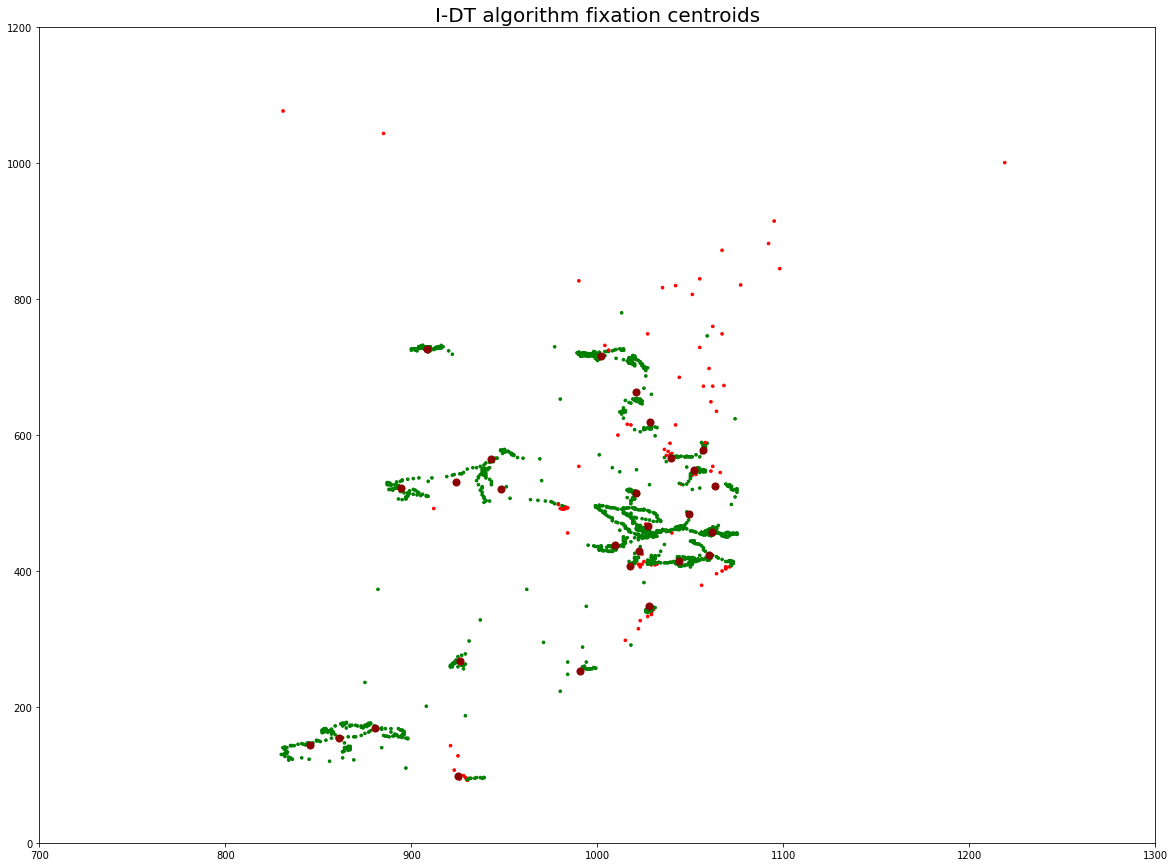

In [10]:
# testing testing

# Running IDT
fixations, fixation_durations, centroids = idt(list(df_et['Gaze point X']), list(df_et['Gaze point Y']),
                                                            list(df_et['Computer timestamp']), 50, 100000)

centroid_x, centroid_y = zip(*centroids)
print('Number of centroids: ', len(centroid_x))
print('Number of fixation durations: ', len(fixation_durations))
print('Number of fixations in Tobii I-VT: ', len(df_et_unique))

fixation_timepoints = []

for fixation_period in fixations:
    asd = df_et[df_et['Computer timestamp'].between(fixation_period[0], fixation_period[1])]
    for val in asd['Computer timestamp'].values:
        fixation_timepoints.append(val)
        
fixation_timepoints = np.array(fixation_timepoints).ravel()

# Plotting stuff
mask = (df_et['Computer timestamp'].isin(fixation_timepoints))
our_colors = ['green' if x else 'red' for x in mask]


fig = plt.figure()
fig.set_size_inches(20,15)
ax = plt.gca()
ax.scatter(df_et['Gaze point X'], df_et['Gaze point Y'], color=our_colors, s=7)
ax.scatter(centroid_x, centroid_y, color='darkred', s=50)
ax.set_title('I-DT algorithm fixation centroids', fontdict={'fontsize':20})
plt.xlim([700, 1300])
plt.ylim([0, 1200])


## 3. Data-analysis

In [15]:
def mfd(fixation_durations):
    return np.mean(fixation_durations)


def get_saccade_amplitude(fix1, fix2):
    """
    Yksittäisen saccaden amplitudi
    TODO lasketaanko ensimmäisen fiksaation viimeisestä pisteestä seuraavan ensimmäiseen
    vai vertaillaanko kahden peräkkäisen fiksaation centroideja?
    """
    
    # kahden pisteen välinen etäisyys 
    dist = np.linalg.norm(fix1, fix2)

    # TODO kulmayksikköjen laskeminen
    return dist  # ja jotain ei jaksa nyt miettii :DDDDD


def msa(fixations):
    # TODO saadaan yksittäiset saccade amplitudit kutsumalla ylempää
    pass


In [12]:
sidMFD = {}

for subject, sample_list in sample_dict.items():
    
    for sample in sample_list:
        
        # Artificial timeline in microseconds
        sampfreq = 1000
        sampling_period = int(1 / sampfreq * 10**6)
        t = np.arange(0, len(sample.xi) * sampling_period, sampling_period)
        
        fixations, fixation_durations, centroids = idt(sample.xi, sample.yi, t, 50, 100000)
        
        MFD = mfd(fixation_durations)
        
        # TODO
        MSA = msa(fixations)
        
        # Jotain luettavaa ettei kyllästy
        # print(f'Subject {subject} MFD for this sample: {MFD:.1f}')
        
        sidMFD.setdefault(subject, []).append((sample.known, MFD))
        
for key, val in sidMFD.items():
    print(key, len(val), val[0:3])

s5 34 [('true', 172.0), ('true', 171.0), ('true', 144.66666666666666)]
s17 23 [('false', 162.2), ('false', 247.6), ('true', 209.2)]
s19 14 [('false', 150.83333333333334), ('false', 135.25), ('false', 191.75)]
s31 33 [('true', 275.0), ('false', 118.42857142857143), ('false', 191.375)]
s3 29 [('true', 223.75), ('false', 220.33333333333334), ('false', 202.25)]
s11 10 [('true', 176.5), ('true', 267.7142857142857), ('false', 146.5)]
s25 17 [('false', 181.0), ('false', 183.0), ('false', 171.25)]
s33 33 [('false', 204.0), ('false', 209.5), ('false', 299.6666666666667)]


## 4. CSV-file from the analysed data

In [13]:
header = [
    'subject_id',
    'MFD_true',
    'MFD_SD_true',
    'MFD_false',
    'MFD_SD_false',
    'MSA_true',
    'MSA_SD_true',
    'MSA_false',
    'MSA_SD_false',
    'MFD_overall',
    'MFD_overall_SD',
    'MSA_overall',
    'MSA_overall_SD',
]


In [14]:
# kirjoitellaan csv-tiedosto
with open("./results_group_3.csv", "w", encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([i.lower().strip() for i in header])

    # TODO laskettujen arvojen kirjoittelut per subject eli rivejä yhtä monta kuin subjekteja?


## 5. Visualization and plots